In [12]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.linalg import solve, block_diag

module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from dynamics_new import a_grav, da_grav_dp_vec, d2a_grav_dp_vec_dp_vecT, a_J2, da_J2_dp_vec, d2a_J2_dp_vec_dp_vecT, a_drag, da_drag_dp_vec, da_drag_dv_vec, d2a_drag_dp_vec_dp_vecT, d2a_drag_dp_vec_dv_vecT, d2a_drag_dv_vec_dp_vecT, d2a_drag_dv_vec_dv_vecT
from utils import get_form_initial_conditions

In [13]:
# Simulation parameters
dt = 60.0  # Time step [s]
K = 395  # Duration [min]
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6 
n_p = 3  
n = N * n_x
o = 3 + 3
H = 15 # Window size [min]
invalid_rmse = 1e20 # [m]

In [14]:
# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(3)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P_0 = np.diag(np.concatenate([p_pos_initial * np.ones(3), p_vel_initial * np.ones(3)])) ** 2
P_0 = block_diag(P_0, P_0, P_0, P_0)

In [15]:
def diff_eq(x_vec):
    x_dot_vec = np.zeros_like(x_vec)
    for i in range(N):
        x_vec_i = x_vec[i * n_x : i * n_x + n_x]
        v_vec_i = x_vec_i[n_p : n_x] 
        x_dot_vec[i * n_x : i * n_x + n_x] = np.concatenate((v_vec_i, a_grav(x_vec_i)))# + a_J2(x_vec_i) + a_drag(x_vec_i)))
    return x_dot_vec

def Ddiff_eq(x_vec):
    first_order_der = np.zeros((n, n))
    for i in range(N):
        x_vec_i = x_vec[i * n_x : i * n_x + n_x]
        first_order_der[i * n_x : i * n_x + n_p, i * n_x + n_p : i * n_x + n_x] = np.eye(n_p)
        first_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p] = da_grav_dp_vec(x_vec_i)# + da_J2_dp_vec(x_vec_i) + da_drag_dp_vec(x_vec_i)
        # first_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x + n_p : i * n_x + n_x] = da_drag_dv_vec(x_vec_i)
    return first_order_der

def Hdiff_eq(x_vec):
    second_order_der = np.zeros((n, n, n))
    for i in range(N):
        x_vec_i = x_vec[i * n_x : i * n_x + n_x]
        aux_pp = (d2a_grav_dp_vec_dp_vecT(x_vec_i)).reshape((n_p, n_p, n_p))# + d2a_J2_dp_vec_dp_vecT(x_vec_i) + d2a_drag_dp_vec_dp_vecT(x_vec_i)).reshape((n_p, n_p, n_p))
        # aux_pv = d2a_drag_dp_vec_dv_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        # aux_vp = d2a_drag_dv_vec_dp_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        # aux_vv = d2a_drag_dv_vec_dv_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        for j in range(n_p): 
            second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p, i * n_x + j] = aux_pp[:, :, j]
            # second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p, i * n_x + j + n_p] = aux_pv[:, :, j]
            # second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x + n_p : i * n_x + n_x, i * n_x + j] = aux_vp[:, :, j]
            # second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x + n_p : i * n_x + n_x, i * n_x + j + n_p] = aux_vv[:, :, j]
    return second_order_der.reshape((n * n, n))

def diff_eq(x_vec):
    x_dot_vec = np.zeros_like(x_vec)
    for i in range(N):
        x_vec_i = x_vec[i * n_x : i * n_x + n_x]
        v_vec_i = x_vec_i[n_p : n_x] 
        x_dot_vec[i * n_x : i * n_x + n_x] = np.concatenate((v_vec_i, a_grav(x_vec_i) + a_J2(x_vec_i) + a_drag(x_vec_i)))
    return x_dot_vec

def Ddiff_eq(x_vec):
    first_order_der = np.zeros((n, n))
    for i in range(N):
        x_vec_i = x_vec[i * n_x : i * n_x + n_x]
        first_order_der[i * n_x : i * n_x + n_p, i * n_x + n_p : i * n_x + n_x] = np.eye(n_p)
        first_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p] = da_grav_dp_vec(x_vec_i) + da_J2_dp_vec(x_vec_i) + da_drag_dp_vec(x_vec_i)
        first_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x + n_p : i * n_x + n_x] = da_drag_dv_vec(x_vec_i)
    return first_order_der

def Hdiff_eq(x_vec):
    second_order_der = np.zeros((n, n, n))
    for i in range(N):
        x_vec_i = x_vec[i * n_x : i * n_x + n_x]
        aux_pp = (d2a_grav_dp_vec_dp_vecT(x_vec_i) + d2a_J2_dp_vec_dp_vecT(x_vec_i) + d2a_drag_dp_vec_dp_vecT(x_vec_i)).reshape((n_p, n_p, n_p))
        aux_pv = d2a_drag_dp_vec_dv_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        aux_vp = d2a_drag_dv_vec_dp_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        aux_vv = d2a_drag_dv_vec_dv_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        for j in range(n_p): 
            second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p, i * n_x + j] = aux_pp[:, :, j]
            second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p, i * n_x + j + n_p] = aux_pv[:, :, j]
            second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x + n_p : i * n_x + n_x, i * n_x + j] = aux_vp[:, :, j]
            second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x + n_p : i * n_x + n_x, i * n_x + j + n_p] = aux_vv[:, :, j]
    return second_order_der.reshape((n * n, n))

def f(dt, x_old):
    k1 = diff_eq(x_old)
    k2 = diff_eq(x_old + dt / 2 * k1)
    k3 = diff_eq(x_old + dt / 2 * k2)
    k4 = diff_eq(x_old + dt * k3)
    return x_old + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

def Df(dt, x_old):
    k1 = diff_eq(x_old)
    k2 = diff_eq(x_old + dt / 2 * k1)
    k3 = diff_eq(x_old + dt / 2 * k2)

    Dk1 = Ddiff_eq(x_old)
    Dk2 = Ddiff_eq(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = Ddiff_eq(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)
    Dk4 = Ddiff_eq(x_old + dt * k3) @ (np.eye(n) + dt * Dk3)
    return np.eye(n) + dt / 6 * (Dk1 + 2 * Dk2 + 2 * Dk3 + Dk4)

def Hf(dt, x_old):
    k1 = diff_eq(x_old)
    k2 = diff_eq(x_old + dt / 2 * k1)
    k3 = diff_eq(x_old + dt / 2 * k2)

    Dk1 = Ddiff_eq(x_old)
    Dk2 = Ddiff_eq(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = Ddiff_eq(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)

    Hk1 = Hdiff_eq(x_old)
    Hk2 = np.kron(np.eye(n), np.eye(n) + dt / 2 * Dk1).T @ Hdiff_eq(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1) + np.kron(Ddiff_eq(x_old + dt / 2 * k1), np.eye(n)) @ (dt / 2 * Hk1)
    Hk3 = np.kron(np.eye(n), np.eye(n) + dt / 2 * Dk2).T @ Hdiff_eq(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2) + np.kron(Ddiff_eq(x_old + dt / 2 * k2), np.eye(n)) @ (dt / 2 * Hk2)
    Hk4 = np.kron(np.eye(n), np.eye(n) + dt * Dk3).T @ Hdiff_eq(x_old + dt * k3) @ (np.eye(n) + dt * Dk3) + np.kron(Ddiff_eq(x_old + dt * k3), np.eye(n)) @ (dt * Hk3)
    return dt / 6 * (Hk1 + 2 * Hk2 + 2 * Hk3 + Hk4)

In [16]:
def h(x_vec):
    p_vecs = [x_vec[i : i + n_p] for i in range(0, n, n_x)]
    distances = [np.linalg.norm(p_vecs[j] - p_vecs[i]) for (i, j) in [(1, 0), (2, 0), (3, 0)]]
    return np.concatenate((p_vecs[0], np.array(distances).reshape(-1, 1)))

def Dh(x_vec):
    first_order_der = np.zeros((o, n))
    p_vecs = [x_vec[i : i + n_p] for i in range(0, n, n_x)]
    
    first_order_der[:n_p, :n_p] = np.eye(n_p)
    
    for k, (i, j) in enumerate([(1, 0), (2, 0), (3, 0)], start=n_p):
        d = p_vecs[j] - p_vecs[i]
        norm_d = np.linalg.norm(d)
        first_order_der[k, i * n_x : i * n_x + n_p] = -d.T / norm_d
        first_order_der[k, j * n_x : j * n_x + n_p] = d.T / norm_d
    
    return first_order_der

def Hh(x_vec):
    second_order_der = np.zeros((o, n, n))
    p_vecs = [x_vec[i : i + n_p] for i in range(0, n, n_x)]

    def hessian_distance(d, norm_d):
        I = np.eye(n_p)
        return -(I / norm_d - np.outer(d, d) / norm_d**3)

    for k, (i, j) in enumerate([(1, 0), (2, 0), (3, 0)], start=n_p):
        d = p_vecs[j] - p_vecs[i]
        norm_d = np.linalg.norm(d)
        hess_d = hessian_distance(d, norm_d)
        
        second_order_der[k, i * n_x : i * n_x + n_p, i * n_x : i * n_x + n_p] = -hess_d
        second_order_der[k, i * n_x : i * n_x + n_p, j * n_x : j * n_x + n_p] = hess_d
        second_order_der[k, j * n_x : j * n_x + n_p, i * n_x : i * n_x + n_p] = hess_d
        second_order_der[k, j * n_x : j * n_x + n_p, j * n_x : j * n_x + n_p] = -hess_d
    
    return second_order_der.reshape((o * n, n))

In [17]:
def J_tau(tau, dt, y, x_vec):
    for _ in range(tau):
        x_vec = f(dt, x_vec)
    return 1 / 2 * (y - h(x_vec)).T @ np.linalg.inv(R) @ (y - h(x_vec))

def DJ_tau(tau, dt, y, x_vec):
    STM = np.eye(n)
    for _ in range(tau):
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    return -STM.T @ Dh(x_vec).T @ np.linalg.inv(R) @ (y - h(x_vec))

def HJ_tau(tau, dt, y, x_vec):
    STM = np.eye(n)
    DSTM = np.zeros((n * n, n))
    for _ in range(tau):
        DSTM = np.kron(np.eye(n), STM).T @ Hf(dt, x_vec) @ STM + np.kron(Df(dt, x_vec), np.eye(n)) @ DSTM
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    
    Df_x = STM
    Hf_x = DSTM    
    h_x = h(x_vec)
    Dh_x = Dh(x_vec)
    Hh_x = Hh(x_vec)
    R_inv = np.linalg.inv(R)
    return - (np.kron(R_inv @ (y - h_x), Df_x).T @ Hh_x @ Df_x + np.kron(Dh_x.T @ R_inv @ (y - h_x), np.eye(n)).T @ Hf_x) + Df_x.T @ Dh_x.T @ R_inv @ Dh_x @ Df_x

In [18]:
def J(k, dt, Y, x_vec):
    if k < H - 1 or k + 1 > K:
        raise ValueError("k is out of bounds")
    R_inv = np.linalg.inv(R)
    J_x = 0
    for tau in range(k - H + 1, k + 1):
        y = Y[:, :, tau]
        h_x = h(x_vec)
        J_x += 1 / 2 * (y - h_x).T @ R_inv @ (y - h_x)
        x_vec = f(dt, x_vec)
    return J_x

def DJ(k, dt, Y, x_vec):
    if k < H - 1 or k + 1 > K:
        raise ValueError("k is out of bounds")
    R_inv = np.linalg.inv(R)
    STM = np.eye(n)
    DJ_x = np.zeros((n, 1))
    for tau in range(k - H + 1, k + 1):
        y = Y[:, :, tau]
        DJ_x += -STM.T @ Dh(x_vec).T @ R_inv @ (y - h(x_vec))
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    return DJ_x

def HJ(k, dt, Y, x_vec):
    if k < H - 1 or k + 1 > K:
        raise ValueError("k is out of bounds")
    R_inv = np.linalg.inv(R)
    STM = np.eye(n)
    DSTM = np.zeros((n * n, n))
    HJ_x = np.zeros((n, n))
    for tau in range(k - H + 1, k + 1):
        y = Y[:, :, tau]
        h_x = h(x_vec)
        Dh_x = Dh(x_vec)
        Hh_x = Hh(x_vec)
        Df_x = STM
        Hf_x = DSTM
        HJ_x += - (np.kron(R_inv @ (y - h_x), Df_x).T @ Hh_x @ Df_x + np.kron(Dh_x.T @ R_inv @ (y - h_x), np.eye(n)).T @ Hf_x) + Df_x.T @ Dh_x.T @ R_inv @ Dh_x @ Df_x
        DSTM = np.kron(np.eye(n), STM).T @ Hf(dt, x_vec) @ STM + np.kron(Df(dt, x_vec), np.eye(n)) @ DSTM
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    return HJ_x

In [19]:
class TreeNewton:
    def __init__(self, tolerance=1e-6, max_iter=20):
        self.grad_tol = tolerance
        self.max_iter = max_iter
        self.iterations = None
        
        # Storage for results
        self.cost_values = []
        self.gradient_norm_values = []

    def solve(self, k, dt, Y, x_init, x_true_initial, x_true_end):
        x = x_init.copy()

        prev_cost_value = None
        prev_gradient_norm_value = None
        prev_global_estimation_error = None
        grad_norm_order_history = []

        for iteration in range(self.max_iter + 1):
            # Compute the cost function, gradient of the Lagrangian and Hessian of the Lagrangian
            J_x = J(k, dt, Y, x)
            DJ_x = DJ(k, dt, Y, x)
            HJ_x = HJ(k, dt, Y, x)

            # Convergence tracking
            cost_value = J_x[0][0]
            gradient_norm_value = np.linalg.norm(DJ_x)

            # Store the values
            self.cost_values.append(cost_value)
            self.gradient_norm_values.append(gradient_norm_value)

            # Metrics
            if prev_cost_value is not None:
                cost_value_change = (cost_value - prev_cost_value) / abs(prev_cost_value) * 100
                gradient_norm_value_change = (gradient_norm_value - prev_gradient_norm_value) / abs(prev_gradient_norm_value) * 100
                global_estimation_error_change = (np.linalg.norm(x - x_true_initial) - prev_global_estimation_error) / abs(prev_global_estimation_error) * 100
            prev_cost_value = cost_value
            prev_gradient_norm_value = gradient_norm_value
            prev_global_estimation_error = np.linalg.norm(x - x_true_initial)
            
            # Track gradient norm order of magnitude
            current_order = int(np.floor(np.log10(gradient_norm_value + 1e-12)))  # avoid log(0)
            grad_norm_order_history.append(current_order)

            if len(grad_norm_order_history) >= 3:
                if grad_norm_order_history[-1] == grad_norm_order_history[-2] == grad_norm_order_history[-3]:
                    stagnant_order = True
                    if k == H - 1:
                        stagnant_order = False
                else:
                    stagnant_order = False
            else:
                stagnant_order = False
            
            # Propagate window initial conditions for metrics 
            x_end = x.copy()
            for _ in range(H - 1):
                x_end = f(dt, x_end)

            # Check convergence and print metrics
            if gradient_norm_value < self.grad_tol or iteration == self.max_iter or stagnant_order:
                reason = "tolerance reached" if gradient_norm_value < self.grad_tol else \
                        "max iteration reached" if iteration == self.max_iter else \
                        "gradient norm stagnated"
                print(f"STOP on Iteration {iteration} ({reason})")
                print(f"Cost function = {cost_value} ({cost_value_change:.2f}%)\nGradient norm = {gradient_norm_value} ({gradient_norm_value_change:.2f}%)\nGlobal estimation error = {np.linalg.norm(x - x_true_initial)} ({global_estimation_error_change:.2f}%)")
                print(f"Final initial conditions estimation errors: {np.linalg.norm(x[:n_p, :] - x_true_initial[:n_p, :])} m, {np.linalg.norm(x[n_x : n_x + n_p, :] - x_true_initial[n_x : n_x + n_p, :])} m, {np.linalg.norm(x[2 * n_x : 2 * n_x + n_p, :] - x_true_initial[2 * n_x : 2 * n_x + n_p, :])} m, {np.linalg.norm(x[3 * n_x : 3 * n_x + n_p, :] - x_true_initial[3 * n_x : 3 * n_x + n_p, :])} m")
                print(f"Final position estimation errors: {np.linalg.norm(x_end[:n_p, :] - x_true_end[:n_p, :])} m, {np.linalg.norm(x_end[n_x : n_x + n_p, :] - x_true_end[n_x : n_x + n_p, :])} m, {np.linalg.norm(x_end[2 * n_x : 2 * n_x + n_p, :] - x_true_end[2 * n_x : 2 * n_x + n_p, :])} m, {np.linalg.norm(x_end[3 * n_x : 3 * n_x + n_p, :] - x_true_end[3 * n_x : 3 * n_x + n_p, :])} m\n")
                break
            else:
                if iteration == 0:
                    print(f"Before applying the algorithm\nCost function: {cost_value}\nGradient norm: {gradient_norm_value}\nGlobal estimation error: {np.linalg.norm(x - x_true_initial)}")
                else:
                    print(f"Iteration {iteration}\nCost function: {cost_value} ({cost_value_change:.2f}%)\nGradient norm: {gradient_norm_value} ({gradient_norm_value_change:.2f}%)\nGlobal estimation error: {np.linalg.norm(x - x_true_initial)} ({global_estimation_error_change:.2f}%)")
                    
            # Print estimation errors 
            print(f"Initial conditions estimation errors: {np.linalg.norm(x[:n_p, :] - x_true_initial[:n_p, :])} m, {np.linalg.norm(x[n_x : n_x + n_p, :] - x_true_initial[n_x : n_x + n_p, :])} m, {np.linalg.norm(x[2 * n_x : 2 * n_x + n_p, :] - x_true_initial[2 * n_x : 2 * n_x + n_p, :])} m, {np.linalg.norm(x[3 * n_x : 3 * n_x + n_p, :] - x_true_initial[3 * n_x : 3 * n_x + n_p, :])} m")
            print(f"Position estimation errors: {np.linalg.norm(x_end[:n_p, :] - x_true_end[:n_p, :])} m, {np.linalg.norm(x_end[n_x : n_x + n_p, :] - x_true_end[n_x : n_x + n_p, :])} m, {np.linalg.norm(x_end[2 * n_x : 2 * n_x + n_p, :] - x_true_end[2 * n_x : 2 * n_x + n_p, :])} m, {np.linalg.norm(x_end[3 * n_x : 3 * n_x + n_p, :] - x_true_end[3 * n_x : 3 * n_x + n_p, :])} m\n")
                
            # Solve for the Newton step - this is one iteration
            delta_x = solve(HJ_x, -DJ_x)
            x += delta_x
        
            # Save the current iteration
            self.iterations = iteration + 1
            
        # Propagate window initial conditions getting estimate at timestamp k
        x_init = x
        for _ in range(H - 1):
            x = f(dt, x)

        return x_init, x

In [20]:
def plots(algorithm_class):
    iterations = np.arange(0, algorithm_class.iterations + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1
    axs[0].semilogy(iterations, 1 / H * np.array(algorithm_class.cost_values), '.-')
    axs[0].set_xlabel(r'$n$')
    axs[0].set_ylabel(r'$\frac{1}{H}J(x_n)$')
    axs[0].set_title('Normalized Cost Function')
    axs[0].grid()

    # Plot 2
    axs[1].semilogy(iterations, 1 / H * np.array(algorithm_class.gradient_norm_values), '.-')
    axs[1].set_xlabel(r'$n$')
    axs[1].set_ylabel(r'$\frac{1}{H}||\nabla J(x_n)||_2$')
    axs[1].set_title('Normalized Gradient Norm')
    axs[1].grid()

    plt.tight_layout()
    plt.show()

In [21]:
np.random.seed(42)

# Initial conditions for the state vector and true state vectors
X_initial = get_form_initial_conditions(formation)
# X_true = np.zeros((n, 1, K))
# X_true[:, :, 0] = X_initial
# for k in range(K - 1):
#     X_true[:, :, k + 1] = f(dt, X_true[:, :, k])
with open(f"tudatpy_form{formation}.pkl", "rb") as file:
    X_true = pickle.load(file)

# Initial position estimation error
X_est = np.zeros_like(X_true)
X_est[:, :, 0] = X_initial + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))
for k in range(K - 1):
    X_est[:, :, k + 1] = f(dt, X_est[:, :, k])
position_estimation_error_1_initial = np.linalg.norm(X_est[:n_p, :, :] - X_true[:n_p, :, :], axis=0).reshape(-1, 1)
position_estimation_error_2_initial = np.linalg.norm(X_est[n_x:n_x + n_p, :, :] - X_true[n_x:n_x + n_p, :, :], axis=0).reshape(-1, 1)
position_estimation_error_3_initial = np.linalg.norm(X_est[2 * n_x:2 * n_x + n_p, :, :] - X_true[2 * n_x:2 * n_x + n_p, :, :], axis=0).reshape(-1, 1)
position_estimation_error_4_initial = np.linalg.norm(X_est[3 * n_x:3 * n_x + n_p, :, :] - X_true[3 * n_x:3 * n_x + n_p, :, :], axis=0).reshape(-1, 1)

MC run:   0%|          | 0/1 [00:00<?, ?it/s]

------------------------------------ Monte Carlo run #1 ------------------------------------


Before applying the algorithm
Cost function: 23235908.394902542
Gradient norm: 115219339.88578565
Global estimation error: 308.80514295296
Initial conditions estimation errors: 171.99589160362004 m, 92.25127812701207 m, 102.74720375246275 m, 216.1266811120975 m
Position estimation errors: 212.08016783830053 m, 291.21244589769367 m, 309.1773750877856 m, 166.99798608159423 m

Iteration 1
Cost function: 35592.5310646015 (-99.85%)
Gradient norm: 30712.781798821645 (-99.97%)
Global estimation error: 461.9115816010422 (49.58%)
Initial conditions estimation errors: 13.483758035587694 m, 218.15551381030477 m, 217.80615303009952 m, 343.72795695599183 m
Position estimation errors: 10.391915188711991 m, 106.22257558348647 m, 142.74335832198443 m, 207.3232825151103 m

Iteration 2
Cost function: 37058.60713422783 (4.12%)
Gradient norm: 219327.33849228514 (614.12%)
Global estimation error: 658.8275917271644 (42.63%)
Initial conditions estimation errors: 13.485906137076658 m, 213.70541770412956 m, 19

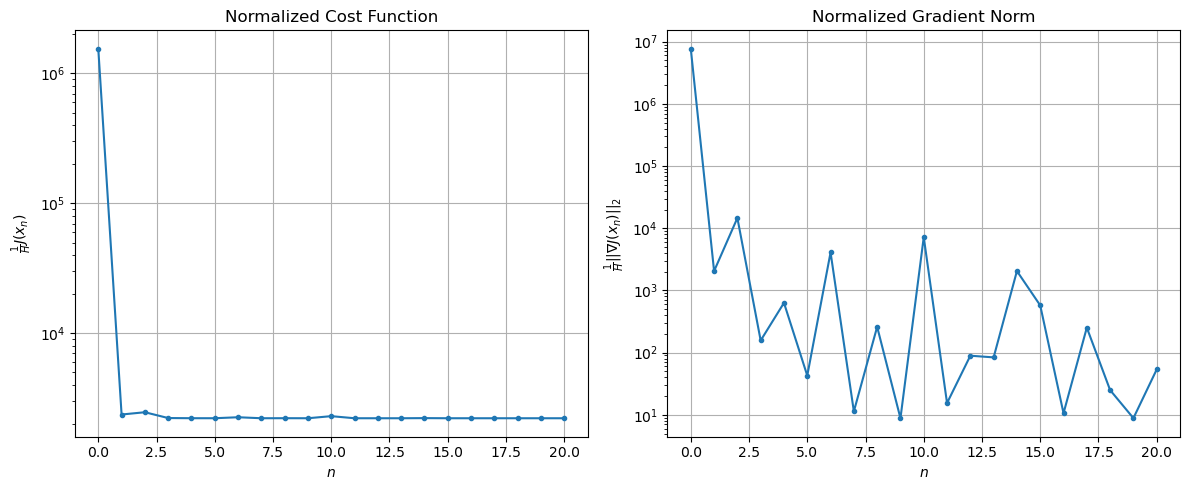

Before applying the algorithm
Cost function: 36002.07238116181
Gradient norm: 1652838.6451202787
Global estimation error: 301.3354174573139
Initial conditions estimation errors: 6.836495874201378 m, 285.1690638768559 m, 84.29748599351139 m, 48.24894706219151 m
Position estimation errors: 15.412585731201888 m, 224.09683059419106 m, 526.6429417364062 m, 331.2114374566935 m

Iteration 1
Cost function: 27798.77423597657 (-22.79%)
Gradient norm: 18759.899090098872 (-98.86%)
Global estimation error: 355.9768947416653 (18.13%)
Initial conditions estimation errors: 12.256081410258329 m, 282.89216053350236 m, 107.37439107631593 m, 187.11294602628143 m
Position estimation errors: 9.796404833514112 m, 225.8205086079074 m, 539.234063646733 m, 396.3406148831124 m

Iteration 2
Cost function: 27423.596500796666 (-1.35%)
Gradient norm: 1950.9065588668907 (-89.60%)
Global estimation error: 348.8996182050263 (-1.99%)
Initial conditions estimation errors: 12.256082049110166 m, 285.3786907917066 m, 86.211

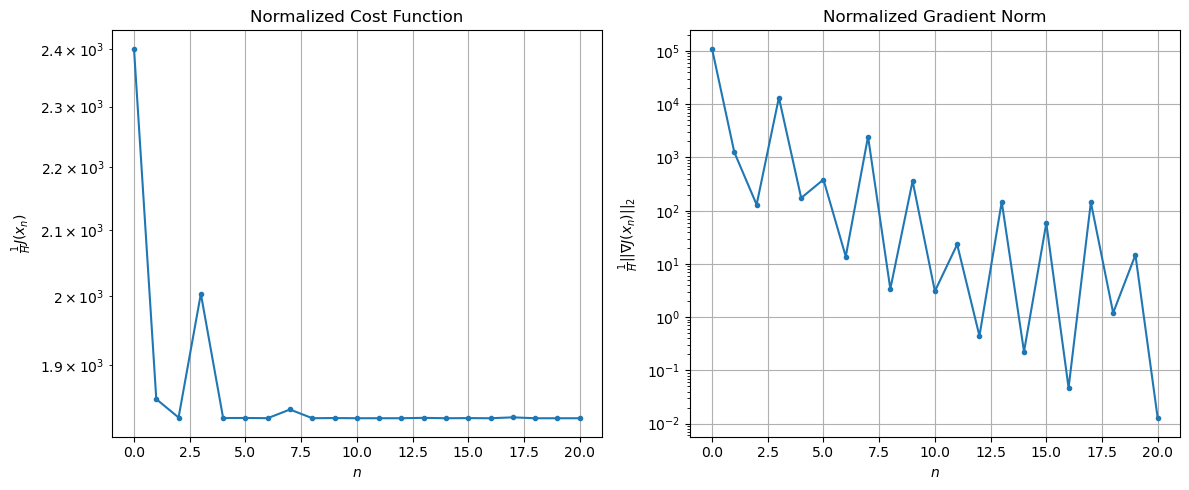

Before applying the algorithm
Cost function: 30736.32482151397
Gradient norm: 1531406.6615116885
Global estimation error: 597.6117943594872
Initial conditions estimation errors: 6.13284779095948 m, 334.32968656390995 m, 490.2715892889948 m, 70.42126249027146 m
Position estimation errors: 14.49174864806422 m, 257.01123712034473 m, 132.0894273619698 m, 126.7232674561984 m

Iteration 1
Cost function: 23487.799070720634 (-23.58%)
Gradient norm: 408.78659248015674 (-99.97%)
Global estimation error: 601.8540437978287 (0.71%)
Initial conditions estimation errors: 11.039364758761565 m, 335.47535171047826 m, 492.1533241803071 m, 85.71591081406463 m
Position estimation errors: 9.282510120468936 m, 257.3761988865086 m, 156.6000394067985 m, 143.8648182643446 m

Iteration 2
Cost function: 23519.86170139922 (0.14%)
Gradient norm: 20194.27217604468 (4840.05%)
Global estimation error: 658.0633121208618 (9.34%)
Initial conditions estimation errors: 11.03936508356539 m, 351.912834446453 m, 553.169213321

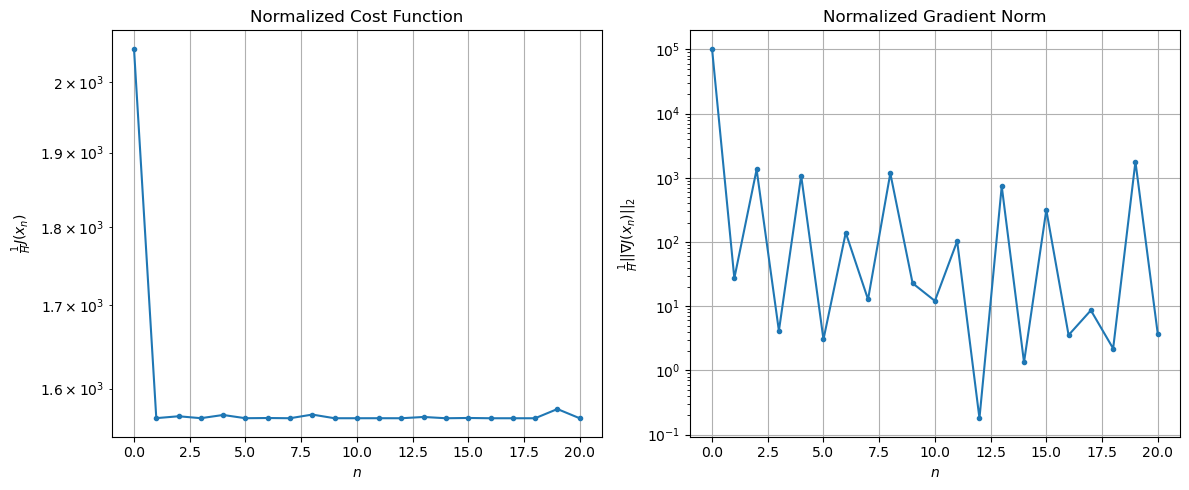

MC run:   0%|          | 0/1 [04:34<?, ?it/s]


KeyboardInterrupt: 

In [22]:
first_round_stop_iteration = []
K_minus_H_next_rounds_stop_iteration = []
for m in tqdm(range(M), desc="MC run", leave=True):
    print(f"------------------------------------ Monte Carlo run #{m + 1} ------------------------------------")
    
    # Observations
    Y = np.zeros((o, 1, K))
    for k in range(K):
        Y[:, :, k] = h(X_true[:, :, k]) + np.random.multivariate_normal(np.zeros(o), R).reshape((o, 1))

    # Cold-start
    x_init = X_initial + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))
    
    # Apply the algorithm
    X_est = np.zeros((n, 1, K))
    for k in tqdm(range(H - 1, K), desc="Windows", leave=False):
        tree_newton = TreeNewton()
        x_init, x_est = tree_newton.solve(k, dt, Y, x_init, X_true[:, :, k - H + 1],  X_true[:, :, k])
        X_est[:, :, k] = x_est
        
        plots(tree_newton)

        if k == 0: # Check divergence in the beginning
            position_estimation_error_init_1, position_estimation_error_init_2, position_estimation_error_init_3, position_estimation_error_init_4 = [], [], [], []
            x_est_tau = x_est
            for tau in range(H):
                position_estimation_error_init_1.append(np.linalg.norm(x_est_tau[:n_p, :] - X_true[:n_p, :, tau]))
                position_estimation_error_init_2.append(np.linalg.norm(x_est_tau[n_x:n_x + n_p, :] - X_true[n_x:n_x + n_p, :, tau]))
                position_estimation_error_init_3.append(np.linalg.norm(x_est_tau[2*n_x:2*n_x + n_p, :] - X_true[2*n_x:2*n_x + n_p, :, tau]))    
                position_estimation_error_init_4.append(np.linalg.norm(x_est_tau[3*n_x:3*n_x + n_p, :] - X_true[3*n_x:3*n_x + n_p, :, tau]))
                x_est_tau = f(dt, x_est_tau)
            rmse_init_1 = np.sqrt(np.mean(np.array(position_estimation_error_init_1) ** 2))
            rmse_init_2 = np.sqrt(np.mean(np.array(position_estimation_error_init_2) ** 2))
            rmse_init_3 = np.sqrt(np.mean(np.array(position_estimation_error_init_3) ** 2))
            rmse_init_4 = np.sqrt(np.mean(np.array(position_estimation_error_init_4) ** 2))
            if rmse_init_1 > invalid_rmse or rmse_init_2 > invalid_rmse or rmse_init_3 > invalid_rmse or rmse_init_4 > invalid_rmse:
                print(f"This Monte Carlo run #{m + 1} diverged!")
            else:
                first_round_stop_iteration.append(tree_newton.iterations)
        else:
            K_minus_H_next_rounds_stop_iteration.append(tree_newton.iterations)

        # Warm-start
        x_init = f(dt, x_init)

    # After each Monte Carlo Run compute the RMSE_m for each K - H + 1 timestamps
    position_estimation_error_1, position_estimation_error_2, position_estimation_error_3, position_estimation_error_4 = [], [], [], []
    rmse_1, rmse_2, rmse_3, rmse_4 = [], [], [], []
    for k in range(H - 1, K):
        position_estimation_error_1.append(np.linalg.norm(X_est[:n_p, :, k] - X_true[:n_p, :, k]))
        position_estimation_error_2.append(np.linalg.norm(X_est[n_x:n_x + n_p, :, k] - X_true[n_x:n_x + n_p, :, k]))
        position_estimation_error_3.append(np.linalg.norm(X_est[2*n_x:2*n_x + n_p, :, k] - X_true[2*n_x:2*n_x + n_p, :, k]))
        position_estimation_error_4.append(np.linalg.norm(X_est[3*n_x:3*n_x + n_p, :, k] - X_true[3*n_x:3*n_x + n_p, :, k]))
    rmse_m_1 = np.sqrt(np.mean(np.array(position_estimation_error_1) ** 2))
    rmse_m_2 = np.sqrt(np.mean(np.array(position_estimation_error_2) ** 2))
    rmse_m_3 = np.sqrt(np.mean(np.array(position_estimation_error_3) ** 2))
    rmse_m_4 = np.sqrt(np.mean(np.array(position_estimation_error_4) ** 2))
    print(f'This MC run RMSE for the {K - H + 1} timestamps:')
    print(f'RMSE_run{m + 1}_1 = {rmse_m_1}')
    print(f'RMSE_run{m + 1}_2 = {rmse_m_2}')
    print(f'RMSE_run{m + 1}_3 = {rmse_m_3}')
    print(f'RMSE_run{m + 1}_4 = {rmse_m_4}\n')
    if rmse_m_1 > invalid_rmse or rmse_m_2 > invalid_rmse or rmse_m_3 > invalid_rmse or rmse_m_4 > invalid_rmse:
        print(f"Discarding this Monte Carlo run #{m + 1} and going to Monte Carlo run #{m + 2}...\n")
    else:
        rmse_1.append(rmse_m_1)
        rmse_2.append(rmse_m_2)
        rmse_3.append(rmse_m_3)
        rmse_4.append(rmse_m_4)
        
print(f'Average RMSE for the {K - H + 1} timestamps for {len(rmse_1)} ({len(rmse_1) / M * 100} %) valid Monte Carlo runs:')
print(f'RMSE_1 = {np.mean(rmse_1)}')
print(f'RMSE_2 = {np.mean(rmse_2)}')
print(f'RMSE_3 = {np.mean(rmse_3)}')
print(f'RMSE_4 = {np.mean(rmse_4)}')
print(f'The first round of CentralizedNewton converged with {np.mean(first_round_stop_iteration)} iterations on average.')
print(f'The next {K - H} rounds of CentralizedNewton converged with {np.mean(K_minus_H_next_rounds_stop_iteration)} iterations on average.')

In [25]:
import pandas as pd
k = H - 1
x_init = X_true[:, :, k - H + 1] + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))

HJ_x = HJ(k, dt, Y, x_init)
print("Hessian matrix eigenvalues:", np.linalg.eigvalsh(HJ_x))
print("Hessian matrix condition number:", np.linalg.cond(HJ_x))
pd.DataFrame(HJ_x)

Hessian matrix eigenvalues: [-2.64499234e-01  2.64195528e-02  8.35094573e-02  1.05745684e-01
  1.87286639e-01  5.18329843e-01  2.47617032e+00  2.70699909e+00
  2.90560279e+00  3.75805456e+02  4.37361732e+02  4.43798962e+02
  3.66633504e+04  7.08975971e+04  1.27729917e+05  2.25908588e+05
  2.38100921e+05  2.51898503e+05  4.25413573e+06  4.29396032e+06
  4.38193749e+06  3.05087900e+08  3.12626432e+08  5.25316681e+08]
Hessian matrix condition number: 19883632570.78301


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,2.642465e+03,-45.547676,347.274989,1.056354e+06,-2.427572e+04,1.857736e+05,-7.539371,0.201276,-6.332685,-3.584075e+03,...,0.962778,-8.052735e+03,-2.629840e+03,339.877697,-18.212306,4.766671,1.518494,-8.122083e+03,2.953873e+03,336.381352
1,-4.554768e+01,1135.794777,-15.585456,-1.983022e+04,4.619105e+05,-8.587044e+03,0.201252,-0.235860,0.181387,9.777423e+01,...,1.779394,-1.693628e+03,-7.642641e+02,334.098388,4.765160,-1.762068,-0.604148,1.981270e+03,-9.639915e+02,-215.278503
2,3.472750e+02,-15.585456,1257.111664,1.514501e+05,-8.573028e+03,5.282774e+05,-6.333483,0.181427,-11.874863,-2.711161e+03,...,-3.484336,-1.185055e+02,1.746798e+02,-524.471390,1.515811,-0.603403,-3.650330,-1.116425e+02,-2.498391e+01,-598.418382
3,1.056354e+06,-19830.223632,151450.123374,4.938219e+08,-9.771290e+06,7.481282e+07,-3584.063652,97.786233,-2710.697864,-1.746673e+06,...,-117.399188,-3.943291e+06,-1.209378e+06,12810.497469,-8121.600488,1981.952499,-110.200878,-3.898951e+06,1.394250e+06,6143.172430
4,-2.427572e+04,461910.477574,-8573.028212,-9.771290e+06,3.056900e+08,-4.851664e+06,96.610232,-76.082201,67.068974,4.814965e+04,...,175.044600,-1.209126e+06,-4.826399e+05,69138.606123,2953.185189,-964.139239,-25.548677,1.393972e+06,-6.512689e+05,-33175.026921
5,1.857736e+05,-8587.044246,528277.371576,7.481282e+07,-4.851664e+06,3.433871e+08,-4224.485682,109.495579,-4730.295530,-1.969322e+06,...,-524.496643,1.246223e+04,6.902587e+04,-195298.607460,335.543376,-215.054151,-598.459749,5.671357e+03,-3.298985e+04,-245047.778945
6,-7.539371e+00,0.201252,-6.333483,-3.584064e+03,9.661023e+01,-4.224486e+03,7.539733,-0.201288,6.332748,3.584263e+03,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
7,2.012757e-01,-0.235860,0.181427,9.778623e+01,-7.608220e+01,1.094956e+02,-0.201288,0.235853,-0.181408,-9.779247e+01,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
8,-6.332685e+00,0.181387,-11.874863,-2.710698e+03,6.706897e+01,-4.730296e+03,6.332748,-0.181408,11.874240,2.710808e+03,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
9,-3.584075e+03,97.774235,-2711.160552,-1.746673e+06,4.814965e+04,-1.969322e+06,3584.263219,-97.792474,2710.808297,1.746774e+06,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000


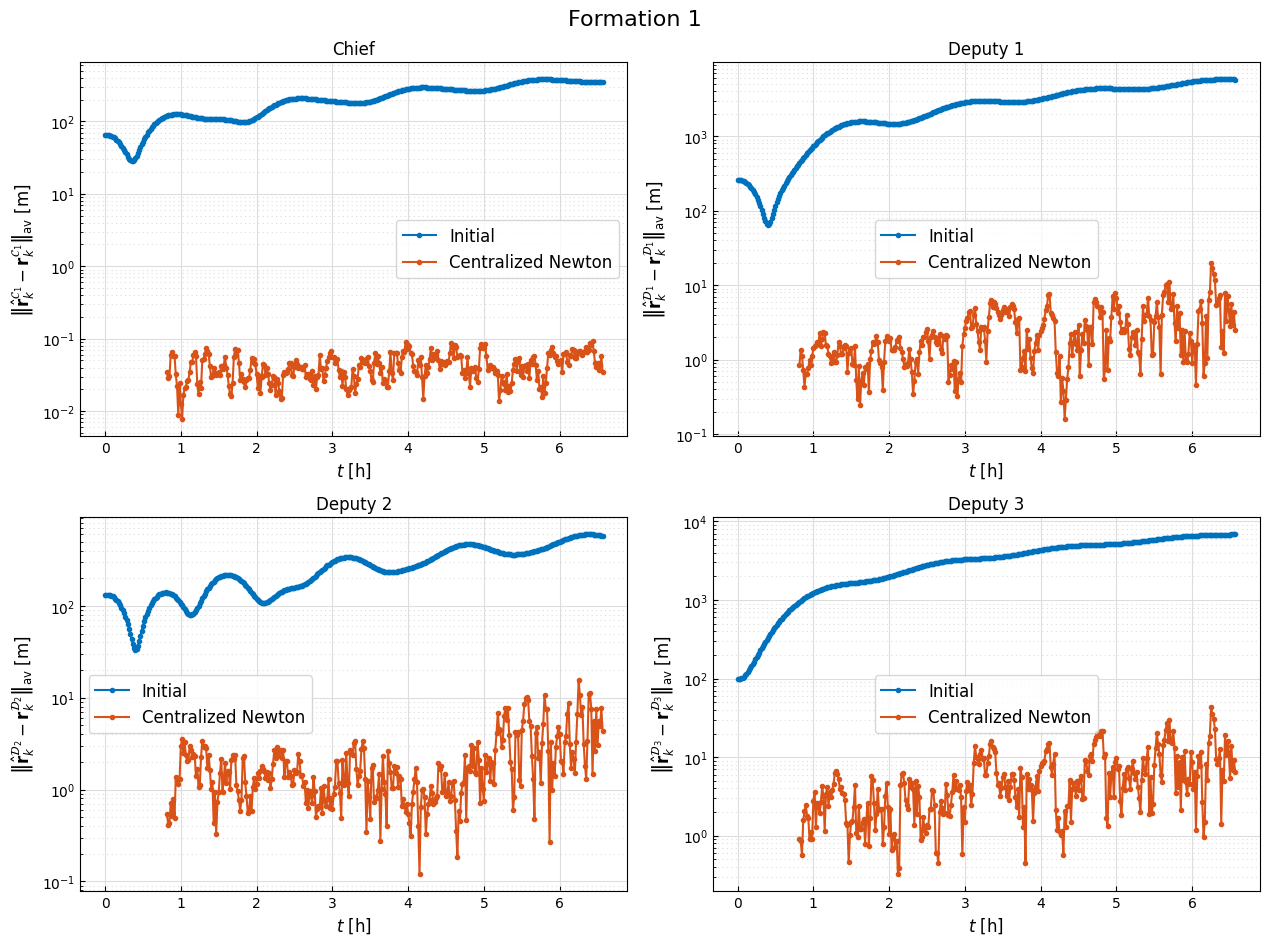

In [ ]:
# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, K) / dt
algorithm = "Centralized Newton"

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, position_estimation_error_1_initial, ".-", label="Initial")
axs[0, 0].plot(time[H - 1:], position_estimation_error_1, ".-", label=algorithm)
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{C}_1} - \\mathbf{r}_k^{\\mathcal{C}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)
axs[0, 0].set_title("Chief")

# Plot 2: Deputy 1
axs[0, 1].plot(time, position_estimation_error_2_initial, ".-", label="Initial")
axs[0, 1].plot(time[H - 1:], position_estimation_error_2, ".-", label=algorithm)
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_1} - \\mathbf{r}_k^{\\mathcal{D}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)
axs[0, 1].set_title("Deputy 1")

# Plot 3: Deputy 2
axs[1, 0].plot(time, position_estimation_error_3_initial, ".-", label="Initial")
axs[1, 0].plot(time[H - 1:], position_estimation_error_3, ".-", label=algorithm)
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_2} - \\mathbf{r}_k^{\\mathcal{D}_2}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)
axs[1, 0].set_title("Deputy 2")

# Plot 4: Deputy 3
axs[1, 1].plot(time, position_estimation_error_4_initial, ".-", label="Initial")
axs[1, 1].plot(time[H - 1:], position_estimation_error_4, ".-", label=algorithm)
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_3} - \\mathbf{r}_k^{\\mathcal{D}_3}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)
axs[1, 1].set_title("Deputy 3")

fig.suptitle(f"Formation {formation}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()